# Практическая работа II - 5

# Задание
1. Подготовьте данные для word2vec по одной из недавно прочитанных книг, удалив все символы, кроме букв и пробелов и обучите модель. Посмотрите результат.
2. Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т.е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas и Water (для дальнейшего предсказания). Графики с результатами только для Liquid.
3. Из этого же текста возьмите небольшой фрагмент, разбейте на предложения с одинаковым числом символов. Каждый символ предложения закодируйте с помощью one hot encoding. В итоге у вас должен получиться массив размера (n_sentences, sentence_len, encoding_size).
4. На полученных в п.3 задании обучение модель RNN для предсказания следующего символа. Посмотрите результат при последовательной генерации.
5. \* (не обязательное) На полученных в п.1 задании обучение модель RNN для предсказания следующего слова. Посмотрите результат при последовательной генерации.

In [1]:
import re

import numpy as np

book_name = "data/svoa-komnata.txt"
with open(book_name) as book:
    book_sentences = re.split(r"[.!?](?!$)", book.read())

In [2]:
import string

sentences = []
max_sentence_len = 12
for sentence in book_sentences:
    sentence = sentence.replace("\n", " ")
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentences.append(sentence)

sentences = [[word for word in sent.lower().split()[:max_sentence_len]]
             for sent in sentences]
print(len(sentences), 'предложений')

1658 предложений


In [3]:
from gensim.models import Word2Vec

sentences_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, epochs=100)

In [4]:
pretrained_weights = sentences_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape
print(vocab_size, embedding_size)

6268 100


In [5]:
print('Похожие слова:')
for word in ['комната', 'я', 'еда', 'деньги', 'женщина', 'свобода']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in sentences_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))


Похожие слова:
  комната -> 1 (0.98), своя (0.98), вулф (0.96), негодование (0.95), профессоров (0.95), i (0.95), название (0.95), html (0.95)
  я -> взглянув (0.85), пейзаж (0.83), открывая (0.82), здешний (0.82), было… (0.79), штука (0.78), загадочная (0.77), затаить (0.77)
  еда -> навсегда (0.99), приживалов (0.99), одежда (0.99), толстякхозяин (0.99), слюной (0.98), брызжа (0.98), соусов (0.98), сладких (0.98)
  деньги -> выигранные (0.87), власть (0.83), следовательно (0.82), непростые (0.81), виноваты (0.81), псу (0.81), производстве (0.81), притихло (0.80)
  женщина -> класса (0.80), садилась (0.78), решала (0.78), среднего (0.77), выходила (0.77), прочитает (0.76), скромная (0.75), семьи (0.75)
  свобода -> вражды (0.87), полнота (0.86), радость (0.85), моста (0.85), горящего (0.85), вовсе (0.85), нечего (0.85), неба (0.84)


In [6]:
# 2. Для обучения на нефтяных скважин добавьте во входные данные информацию со столбцов Gas, Water (т.е. размер x_data будет (440, 12, 3)) и обучите новую модель. Выход содержит Liquid, Gas и Water (для дальнейшего предсказания). Графики с результатами только для Liquid.
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, LSTM, Input
from keras.models import Model

df = pd.read_csv('./data/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [7]:
production = df.groupby('API')['Liquid', 'Gas', 'Water'].apply(lambda df_: df_.reset_index(drop=True))
production.head()

<ipython-input-7-aa95e4268298>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  production = df.groupby('API')['Liquid', 'Gas', 'Water'].apply(lambda df_: df_.reset_index(drop=True))


Liquid    Gas  Water
API                                  
5005072170100 0    9783  11470  10558
              1   24206  26476   5719
              2   20449  26381   2196
              3    6820  10390    583
              4    7349   7005    122

In [8]:
df_prod = production.unstack()
df_prod.head()

Liquid                                                       \
                  0      1      2     3     4      5      6      7     8    
API                                                                         
5005072170100   9783  24206  20449  6820  7349  16552  13844  10655  6135   
5123377130000   2341   4689   3056  1979  2037   2260   1961   1549  1364   
5123379280000   6326   6405   6839  6584  4775   3917   3840   3031  3137   
5123379400000   8644  13977   9325  6445  5326   4538   3403   2534  2685   
5123385820100   1753   4402   1187  1204  1176   1523   1169    782   634   

                      ... Water                                               
                  9   ...    14   15   16   17   18   19   20   21   22   23  
API                   ...                                                     
5005072170100  11105  ...   357  270  242  236  250  200  241  215  194  188  
5123377130000   1380  ...   193  118  111  111   91  100  137  109  113   55  
5123379280000   2669  ...   218  256  203  207  225  180  194  202  182  208  
5123379400000   2597  ...   197  156  193  226  135  190  162  181  189   34  
5123385820100    597  ...   124    0    0    0    0    0  119  568  521  289  

[5 rows x 72 columns]

In [9]:
data = df_prod.values
data = data.reshape((data.shape[0], 3, data.shape[1]//3))
data = np.transpose(data, (0, 2, 1))
data.shape

(50, 24, 3)

In [10]:
max_values = np.zeros(data.shape[-1])
for index in range(len(max_values)):
    max_values[index] = np.amax(data[:,:,index])
max_values

array([ 42345., 110266., 190268.])

In [11]:
data = data / max_values[None, None, :]

In [12]:
data_tr = data[:40]
data_tst = data[40:]
print(data_tr.shape, data_tst.shape)

(40, 24, 3) (10, 24, 3)


In [13]:
x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [14]:
timesteps = 12
inp = Input(shape=(timesteps, 3))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(3, activation="relu")(lstm)

model = Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 32)            4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
dense (Dense)                (None, 12, 3)             99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(x_data, y_data, epochs=20)

Epoch 1/20
14/14 [==============================] - 4s 12ms/step - loss: 0.0133 - mae: 0.0668
Epoch 2/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0084 - mae: 0.0546
Epoch 3/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0074 - mae: 0.0474
Epoch 4/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0060 - mae: 0.0414
Epoch 5/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0054 - mae: 0.0375
Epoch 6/20
14/14 [==============================] - 0s 14ms/step - loss: 0.0045 - mae: 0.0355
Epoch 7/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0046 - mae: 0.0367
Epoch 8/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0048 - mae: 0.0368
Epoch 9/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0039 - mae: 0.0332
Epoch 10/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0331
Epoch 11/20
14/14 [==============================] - 0s 13m

In [16]:
# Предскажем на год вперёд используя данные только первого года
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))

for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    pred = model.predict(x)
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)

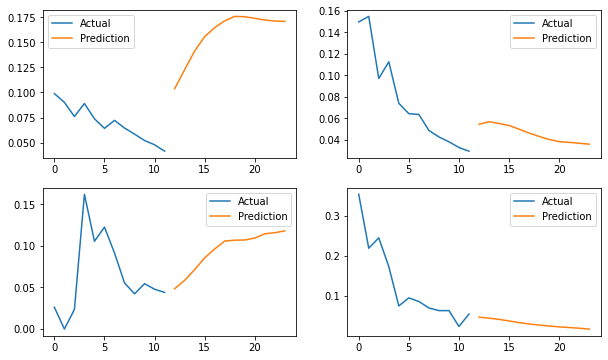

In [17]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for iapi in range(4):
    plt.subplot(2, 2, iapi+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[iapi, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[iapi, :, 0], label='Prediction')
    plt.legend()
plt.show()

In [18]:
# 3. Из этого же текста возьмите небольшой фрагмент, разбейте на предложения с одинаковым числом символов. Каждый символ предложения закодируйте с помощью one hot encoding. В итоге у вас должен получиться массив размера (n_sentences, sentence_len, encoding_size).
import tensorflow as tf


sentence_len = 30
encoding_size = 33
symbols = []
for sentence in sentences:
    join_sentence = ''.join(sentence)
    join_sentence = re.sub(r'[^а-я]', "", join_sentence)
    if len(join_sentence) >= sentence_len:
        idxs = np.array([ord(char) - ord('а') for char in join_sentence])
        one_hot = tf.one_hot(idxs[:sentence_len], encoding_size)
        symbols.append(one_hot)

print(len(symbols))

1412


In [19]:
N_tr = 2 * len(symbols) // 3
tr_data = symbols[:N_tr]
test_data = symbols[N_tr:]

In [20]:
from tensorflow.keras.utils import to_categorical
# train_x = np.array([sentence[:-1] for sentence in tr_data])
# train_y = np.array([sentence[-1:] for sentence in tr_data])
#
# print(train_x.shape, train_y.shape)
#
# test_x = np.array([sentence[:-1] for sentence in test_data])
# test_y = np.array([sentence[-1:] for sentence in test_data])
train_x = np.array([sentence[:-1] for sentence in tr_data])
train_y = np.array([sentence[-1] for sentence in tr_data])

print(train_x.shape, train_y.shape)

test_x = np.array([sentence[:-1] for sentence in test_data])
test_y = np.array([sentence[-1] for sentence in test_data])

# train_y = to_categorical(train_y)

(941, 29, 33) (941, 33)


In [21]:
inp = Input(shape=train_x[0].shape)
lstm = LSTM(units=128)(inp)
out = Dense(encoding_size, activation="softmax")(lstm)

symbols_model = Model(inp, out)
symbols_model.summary()
symbols_model.compile(optimizer='adam', loss='categorical_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29, 33)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82944     
_________________________________________________________________
dense_1 (Dense)              (None, 33)                4257      
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [22]:
symbols_model.fit(train_x, train_y, epochs=40)

Epoch 1/40
30/30 [==============================] - 3s 29ms/step - loss: 3.4230
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 3.1237
Epoch 3/40
30/30 [==============================] - 1s 31ms/step - loss: 3.1231
Epoch 4/40
30/30 [==============================] - 1s 30ms/step - loss: 3.0953
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 3.1294
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 3.0503
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 3.0581
Epoch 8/40
30/30 [==============================] - 1s 28ms/step - loss: 3.0282
Epoch 9/40
30/30 [==============================] - 1s 28ms/step - loss: 3.0419
Epoch 10/40
30/30 [==============================] - 1s 28ms/step - loss: 3.0121
Epoch 11/40
30/30 [==============================] - 1s 29ms/step - loss: 2.9920
Epoch 12/40
30/30 [==============================] - 1s 28ms/step - loss: 2.9546
Epoch 13/40
30/30 [==================

In [25]:
predict_chars = symbols_model.predict(test_x)
accuracy = []
for i, char in enumerate(predict_chars):
    accuracy.append(np.amax(char-test_y[i]))
print(accuracy)

[0.26188526, 0.6963486, 0.52066165, 0.5539427, 0.16782197, 0.20757094, 0.4546588, 0.24000053, 0.6654191, 0.40187028, 0.2671418, 0.2886211, 0.618721, 0.36223748, 0.3020389, 0.25937375, 0.36702982, 0.7750467, 0.3136113, 0.5796729, 0.215528, 0.4587501, 0.22369337, 0.60591906, 0.6265481, 0.28316623, 0.54135704, 0.1466574, 0.56526214, 0.27062044, 0.2854898, 0.18247227, 0.20011774, 0.32585403, 0.3297522, 0.3492694, 0.51719904, 0.4688562, 0.6528541, 0.5386096, 0.2627385, 0.5389189, 0.32875398, 0.24490504, 0.2966268, 0.7702553, 0.44657636, 0.27653947, 0.26743516, 0.11212319, 0.33428743, 0.1727, 0.27148163, 0.14485793, 0.691964, 0.46045825, 0.30744877, 0.23165391, 0.5537077, 0.11480423, 0.38644513, 0.1894556, 0.19307402, 0.37919915, 0.7987607, 0.35653225, 0.26513234, 0.21801913, 0.36470684, 0.70606476, 0.24275209, 0.2709865, 0.110574566, 0.34251037, 0.17184564, 0.20986797, 0.79761565, 0.20628986, 0.21966211, 0.23365249, 0.93952405, 0.37382162, 0.31439528, 0.36007836, 0.7511016, 0.61071503, 0.48